For the theory of **Mixture of Experts**, refer to [notes](https://github.com/phcchan/invNN/blob/master/ML-notes.pdf).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

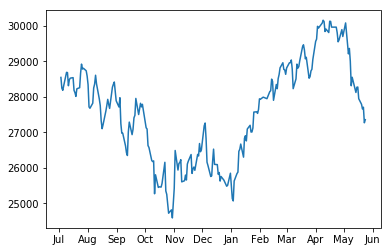

In [2]:
# data: HSI, July 2018 ~ May 2019
hsi = pd.read_csv('data_MoE/HSI.csv', index_col='Date', parse_dates=['Date',])

y0 = hsi.Close.values
#x0 = np.array(range(len(y0)))
x0 = (hsi.index - hsi.index.min()) / np.timedelta64(1,'D')
fig, ax = plt.subplots(1,1)
_ = ax.plot(hsi.index.values, y0)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

N = len(x0)
assert len(y0) == N

In [11]:
# num of runs
runs = 20

# dim of dependent variables (time t, const=1)
Wl = 2

# number of experts
K = 3

# initial guess for the linear functions (a,b) with y=a*x+b
w_k = np.array([[-30,29000],[30,21000],[-70,50000]]).T # shape = (Wl, K)

In [4]:
# some helper functions

from scipy.optimize import minimize as sp_minimize

class fun_w():
    def __init__(self, fun, shape):
        self.fun = fun
        self.shape = shape 
    def __call__(self, x_flat):
        x = x_flat.reshape(self.shape)
        return self.fun(x)

# a wrapper for scipy.optimize.minimize, which only 
# accepts np.array (ndim=1) for x0, while we have ndim>1 for x0.
def minimize(fun, x0, *args, **kwargs):
    x_shape = x0.shape
    _fun_w = fun_w(fun, x_shape)
    return sp_minimize(_fun_w, x0.flatten(), *args, **kwargs)

# normalize the matrix along the specified axis
def normalize(mat, axis=1):
    assert mat.ndim == 2
    norm = np.sum(mat, axis=axis, keepdims=True)
    return mat/norm

def scale_max(mat, axis=1):
    assert mat.ndim == 2
    return mat - np.amax(mat, axis=axis, keepdims=True)

def softmax(mat, axis=1):
    mat = scale_max(mat)
    return normalize(np.exp(mat), axis=axis)

def log_softmax(mat, axis=1):
    mat = scale_max(mat)
    return mat - np.log(np.sum(np.exp(mat), axis=axis, keepdims=True))

In [5]:
X = np.empty([N, Wl], dtype=np.float32)
X[:, 0] = x0
X[:, 1].fill(1.)

def M_step(r_ik, V_ik_0):
    Wl, K = V_ik_0.shape
    w_k = np.empty([Wl, K], dtype=np.float32)
    sigmaSq_k = np.empty(K, dtype=np.float32)
    sumi_r = np.sum(r_ik, axis=0)

    for k in range(K):
        # due to np.diag(), have to use for loop
        XT_Rk = np.transpose(X) @ np.diag(r_ik[:, k])
        w_k[:, k] = np.linalg.pinv(XT_Rk @ X) @ XT_Rk @ y0

    sigmaSq_k = np.sum(
            r_ik * np.square(y0[:, np.newaxis] - np.matmul(X, w_k)), axis=0
    ) / sumi_r
    
    def loss(V_ik):
        log_gating = log_softmax(X @ V_ik, axis=1)
        return -np.sum(r_ik * log_gating)
    
    V_ik = minimize(loss, V_ik_0, method='nelder-mead',
            options={'xtol':1e-6, 'maxiter':10000}
    ).x.reshape(V_ik_0.shape)

    return w_k, sigmaSq_k, V_ik


def E_step(w_k, sigmaSq_k, V_ik):
    log_pi_ik = log_softmax(X @ V_ik, axis=1)
    y_pred = X @ w_k

    # the following might not work due to normal_ik might 
    # overflow/underflow if the factors inside np.exp() are too small/large,
    # which should be 'balanced' by the normalization in the return statement
    # note that we can solve this by softmax function, with eta_ik = log(r_ik * normal_ik)
    '''
    pi_ik = softmax(X @ V_ik, axis=1)
    normal_ik = np.exp(
            -np.square(y0[:,np.newaxis] - y_pred) / (2.*sigmaSq_k[np.newaxis,:])
    ) / (np.sqrt(2.*np.pi*sigmaSq_k[np.newaxis,:]))
    r_ik = pi_ik * normal_ik
    return normalize(r_ik, axis=1)
    '''
    
    log_r_normal_ik = log_pi_ik -np.square(y0[:,np.newaxis] - y_pred) / (2.*sigmaSq_k[np.newaxis,:]) \
                      - np.log(np.sqrt(2.*np.pi*sigmaSq_k[np.newaxis,:]))
    
    return softmax(log_r_normal_ik)

In [12]:
sigmaSq_k = np.full(K, 1., dtype=np.float32)

V_ik = np.abs(np.random.randn(Wl, K))
r_ik = E_step(w_k, sigmaSq_k, V_ik)

for _ in range(runs):
    w_k, sigmaSq_k, V_ik = M_step(r_ik, V_ik_0=V_ik)
    r_ik = E_step(w_k, sigmaSq_k, V_ik)

print('w_k.T\n', w_k.T)
print('sigmaSq_k\n', sigmaSq_k)
print('V_ik\n', V_ik)
print('r_ik\n', r_ik)

w_k.T
 [[ -1.87758064e+01   2.86636250e+04]
 [  2.67916985e+01   2.20450957e+04]
 [ -9.85883179e+01   5.93704375e+04]]
sigmaSq_k
 [ 207312.9366874   225340.83439751   39805.18712824]
V_ik
 [[  -2.46444184   -2.4221541    -0.97126691]
 [  86.55741961   81.20929914 -361.63193661]]
r_ik
 [[  1.00000000e+000   8.99774969e-044   0.00000000e+000]
 [  1.00000000e+000   1.46474278e-039   0.00000000e+000]
 [  1.00000000e+000   1.73859342e-038   0.00000000e+000]
 [  1.00000000e+000   7.56446724e-040   0.00000000e+000]
 [  1.00000000e+000   1.96105716e-043   0.00000000e+000]
 [  1.00000000e+000   5.32582607e-043   0.00000000e+000]
 [  1.00000000e+000   3.55489809e-038   0.00000000e+000]
 [  1.00000000e+000   7.02780590e-040   0.00000000e+000]
 [  1.00000000e+000   4.51361595e-040   0.00000000e+000]
 [  1.00000000e+000   3.23620863e-039   0.00000000e+000]
 [  1.00000000e+000   9.52218441e-035   0.00000000e+000]
 [  1.00000000e+000   1.05483467e-033   0.00000000e+000]
 [  1.00000000e+000   3.455390

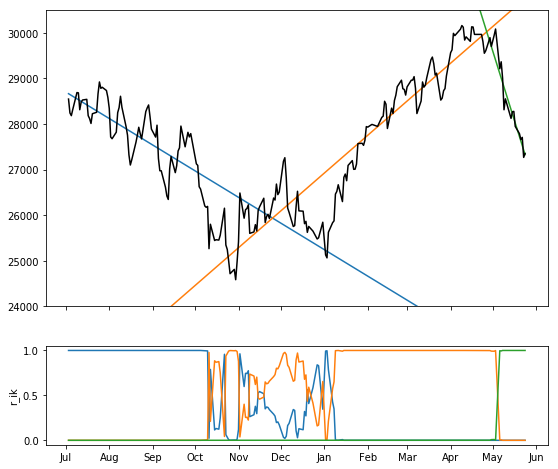

In [15]:
fig, axs = plt.subplots(2,1, figsize=(9, 8), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})

ax = axs[0]
for k in range(K):
    fit = x0*w_k[0,k] + w_k[1,k]
    _ = ax.plot(hsi.index.values, fit)
_ = ax.plot(hsi.index.values, y0, c='k')
_ = ax.set_ylim([24000,30500])


ax = axs[1]
for k in range(K):
    _ = ax.plot(hsi.index.values, r_ik[:,k])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
_ = ax.set_ylabel('r_ik')

Keys:

- $i$ : data points, total of $N$
- $k$ : experts (linear functions), total of $K$
- $r_{ik} = \pi_{ik} \odot p(y_i|x_i, z_i=k) \in [0,1]$ : responsibility for expert $k$ takes for data point $i$, where $\odot$ is elementwise product